# Predicting Flight Delays using Statistics and Machine Learning
 Frank Seely, Emily Zhao, Nick David, Ryan Cheng

**Data Preparation and Cleaning:**
We start by importing our main dataset, "Airlines.csv" (found on Kaggle)

In [29]:
# import statements
import csv

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
from sklearn import tree

# import graphviz
from sklearn.metrics import roc_curve

Read the our main CSV file and display its key information

In [30]:
df = pd.read_csv('Datasets/Airlines.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Length       539383 non-null  int64 
 8   Delay        539383 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 37.0+ MB


,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


Delete unneccesary columns

In [31]:
del df['id']
del df['Flight']
df.head(10)

,Airline,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,CO,SFO,IAH,3,15,205,1
1,US,PHX,CLT,3,15,222,1
2,AA,LAX,DFW,3,20,165,1
3,AA,SFO,DFW,3,20,195,1
4,AS,ANC,SEA,3,30,202,0
5,CO,LAX,IAH,3,30,181,1
6,DL,LAX,MSP,3,30,220,0
7,DL,PHX,DTW,3,30,228,0
8,DL,SFO,MSP,3,35,216,1
9,AA,LAS,ORD,3,40,200,1


Read other CSV which we will use to match airport IATA codes (three letter airport identifiers e.g. JFK, BOS) with their corresponding longitudes. Drop all unneccesary columns and duplicates.

In [32]:
df_long = pd.read_csv('Datasets/iata-icao.csv')

del df_long['country_code']
del df_long['region_name']
del df_long['icao']
del df_long['airport']
del df_long['latitude']

df_long = df_long.rename(columns = {'iata' : 'AirportFrom'})

df_long = df_long.drop_duplicates(subset='AirportFrom')
print(f'\nNumber of duplicates: {sum(df_long.duplicated(subset="AirportFrom"))}')

df_long.head()


Number of duplicates: 0


,AirportFrom,longitude
0,SHJ,55.5172
1,AZI,54.4581
2,FJR,56.3240
3,XSB,52.5803
4,RKT,55.9388


Merge this second dataset with our main dataset on 'AirportFrom'. Keep in mind: running this cell more than once will produce an error as our main datafram 'df' itself is being modified.

We add two columns containing longitudes from where the plane departs ('AirportFrom') and where the plane lands ('AirportTo').

Finally, we add two more columns containing String values of whether the airport is landing/departing from the WEST coast or the EAST coast of the U.S. The meridian that we will use to divide the country is 100 degrees West (-100).

We can now delete 'AirportFrom' and 'AirportTo' as these columns will no longer be needed. We should be left with the columns 'FromCoast' and 'ToCoast'.

In [33]:
# merge the AirportFrom column from the second dataset to the first dataset
df = pd.merge(df, df_long, on='AirportFrom', how='left')
# rename the longitude column to 'FromLongitude' to be more specific
df = df.rename(columns = {'longitude' : 'FromLongitude'})

# rename the column from the second dataset to work with the merge() once again
df_long = df_long.rename(columns = {'AirportFrom' : 'AirportTo'})

# once again merge the AirportTo column from the second dataset to the first dataset
df = pd.merge(df, df_long, on='AirportTo', how='left')
# rename longitude column to 'ToLongitude'
df = df.rename(columns = {'longitude' : 'ToLongitude'})

# add two more columns called FromCoast and ToCoast which tell which side the plane is coming from
    # WEST if latitude is less than 100 degrees West, EAST if latitude is greater than 100 degrees West
df['FromCoast'] = df['FromLongitude'].apply(lambda x: 'WEST' if x < -100 else 'EAST')
df['ToCoast'] = df['ToLongitude'].apply(lambda x: 'WEST' if x < -100 else 'EAST')

del df['FromLongitude']
del df['ToLongitude']

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Airline      539383 non-null  object
 1   AirportFrom  539383 non-null  object
 2   AirportTo    539383 non-null  object
 3   DayOfWeek    539383 non-null  int64 
 4   Time         539383 non-null  int64 
 5   Length       539383 non-null  int64 
 6   Delay        539383 non-null  int64 
 7   FromCoast    539383 non-null  object
 8   ToCoast      539383 non-null  object
dtypes: int64(4), object(5)
memory usage: 37.0+ MB


,Airline,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,FromCoast,ToCoast
0,CO,SFO,IAH,3,15,205,1,WEST,EAST
1,US,PHX,CLT,3,15,222,1,WEST,EAST
2,AA,LAX,DFW,3,20,165,1,WEST,EAST
3,AA,SFO,DFW,3,20,195,1,WEST,EAST
4,AS,ANC,SEA,3,30,202,0,WEST,WEST


Create a simple heatmap using all numeric datatypes. Check for any initial correlations

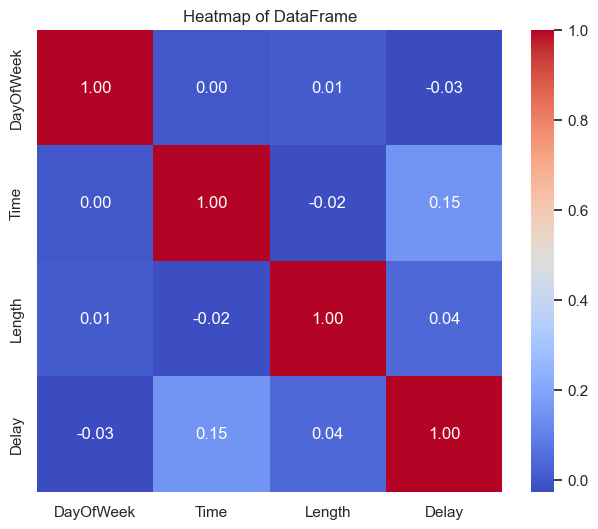

In [34]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])
heatmap_data = numeric_columns.corr()

plt.figure(figsize=(7.5, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of DataFrame')
plt.show()

Not much information gained from the heatmap as little correlation was found between numeric variables. We will now further modify our dataframe based on this outcome.

We now concert the 'Time' columns, which is in minutes from midnight, to 'HourOfDay' which is from hour 0 (midnight) to hour 23 (11PM) for ease of computation.

Similarly, convert 'DayOfWeek' into 'DayOfWeekName' and add a DayType column ('Weekend' vs 'Weekday)

We will also add a 'FlightType' column, which categorizes flights into 'Short-haul' (less than 3 hours), 'Medium-haul' (between 3-6 hours), and 'Long-haul' (greater than 6 hours) flights

In [35]:
df['HourOfDay'] = df['Time'] // 60

# categorize 'Length' into flight types (short, medium, long)
def categorize_flight_length(length):
    if length < 180: return 'Short-haul'
    elif 180 <= length < 360: return 'Medium-haul'
    else: return 'Long-haul'

df['FlightType'] = df['Length'].apply(categorize_flight_length)

# convert 'DayOfWeek' to actual day names
days = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday',
        5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
df['DayOfWeekName'] = df['DayOfWeek'].map(days)

df['DayType'] = df['DayOfWeek'].apply(lambda x: 1 if x < 6 else 0)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Airline        539383 non-null  object
 1   AirportFrom    539383 non-null  object
 2   AirportTo      539383 non-null  object
 3   DayOfWeek      539383 non-null  int64 
 4   Time           539383 non-null  int64 
 5   Length         539383 non-null  int64 
 6   Delay          539383 non-null  int64 
 7   FromCoast      539383 non-null  object
 8   ToCoast        539383 non-null  object
 9   HourOfDay      539383 non-null  int64 
 10  FlightType     539383 non-null  object
 11  DayOfWeekName  539383 non-null  object
 12  DayType        539383 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 53.5+ MB


,Airline,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,FromCoast,ToCoast,HourOfDay,FlightType,DayOfWeekName,DayType
0,CO,SFO,IAH,3,15,205,1,WEST,EAST,0,Medium-haul,Wednesday,1
1,US,PHX,CLT,3,15,222,1,WEST,EAST,0,Medium-haul,Wednesday,1
2,AA,LAX,DFW,3,20,165,1,WEST,EAST,0,Short-haul,Wednesday,1
3,AA,SFO,DFW,3,20,195,1,WEST,EAST,0,Medium-haul,Wednesday,1
4,AS,ANC,SEA,3,30,202,0,WEST,WEST,0,Medium-haul,Wednesday,1


**Visualizations:**
Display key information using various graphs

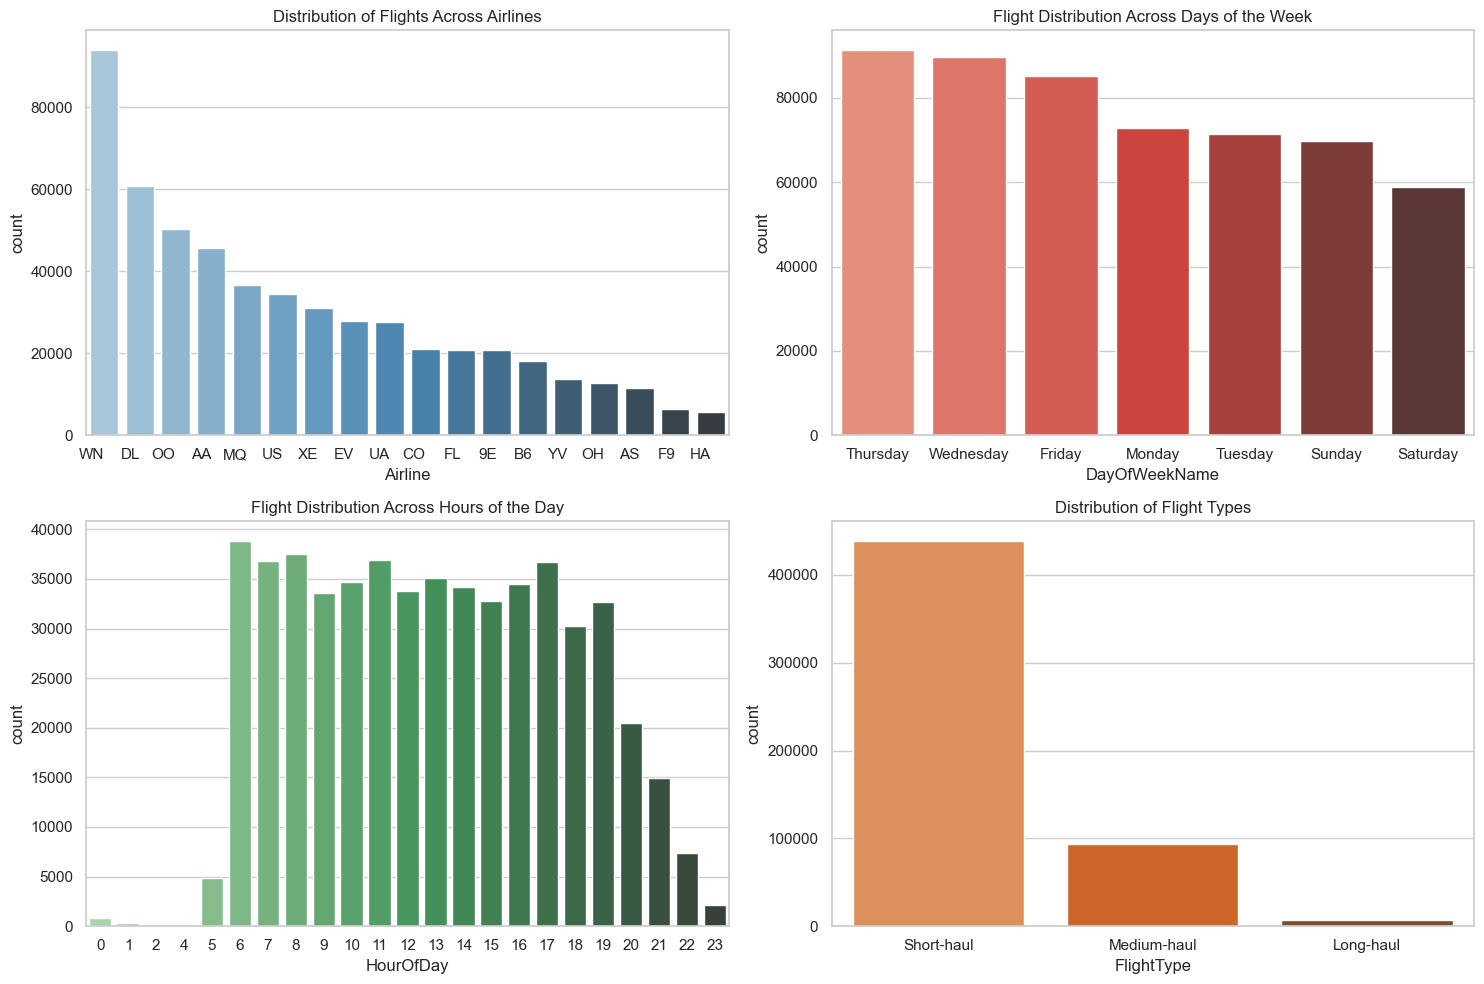

In [36]:
sns.set(style="whitegrid")

# univariate analysis
# distribution of several key variables: 'Airline', 'DayOfWeekName', 'HourOfDay', and 'FlightType'

# subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# airline distribution
shades_palette = sns.color_palette("Blues_d", n_colors=18)
sns.countplot(ax=axes[0, 0], x='Airline', data=df, order=df['Airline'].value_counts().index, palette=shades_palette)
axes[0, 0].set_title('Distribution of Flights Across Airlines')
axes[0, 0].tick_params(axis='x')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), ha='right')

# day of week distribution
shades_palette = sns.color_palette("Reds_d", n_colors=7)
sns.countplot(ax=axes[0, 1], x='DayOfWeekName', data=df, order=df['DayOfWeekName'].value_counts().index, palette=shades_palette)
axes[0, 1].set_title('Flight Distribution Across Days of the Week')

# hour of day distribution
shades_palette = sns.color_palette("Greens_d", n_colors=24)
sns.countplot(ax=axes[1, 0], x='HourOfDay', data=df, palette=shades_palette)
axes[1, 0].set_title('Flight Distribution Across Hours of the Day')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), ha='center')

# flight type distribution
shades_palette = sns.color_palette("Oranges_d", n_colors=3)
sns.countplot(ax=axes[1, 1], x='FlightType', data=df, order=df['FlightType'].value_counts().index, palette=shades_palette)
axes[1, 1].set_title('Distribution of Flight Types')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), ha='center')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Same graphs in relative percentages:

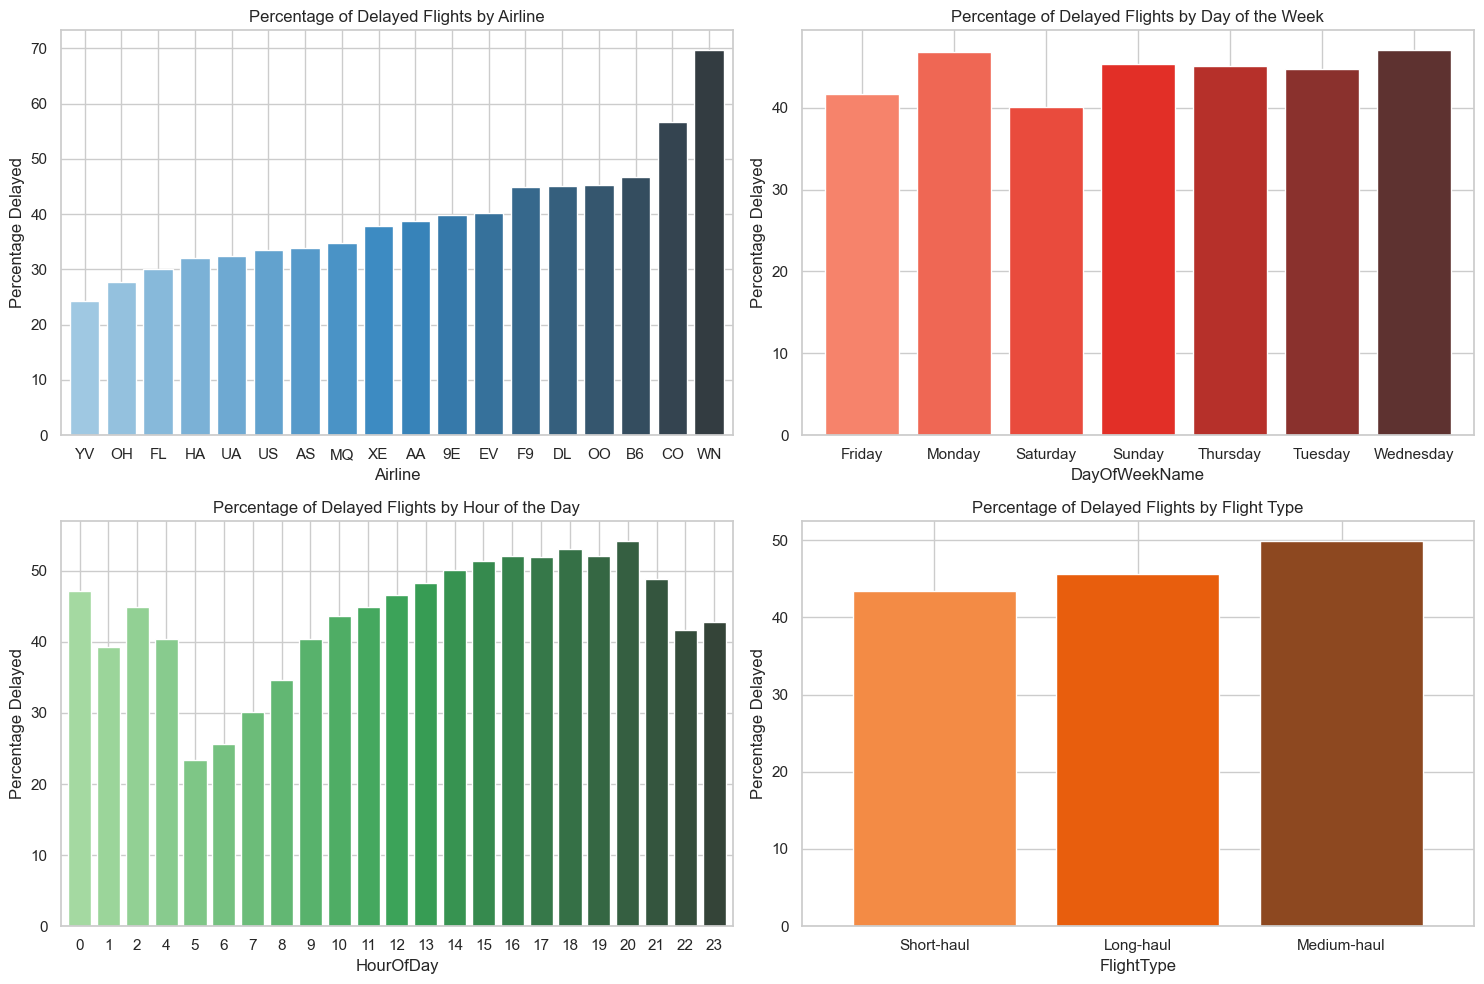

In [37]:
# Adjust layout for better spacing

# percentage calculations:
delay_by_airline = df.groupby('Airline')['Delay'].mean() * 100
delay_by_day = df.groupby('DayOfWeekName')['Delay'].mean() * 100
delay_by_hour = df.groupby('HourOfDay')['Delay'].mean() * 100
delay_by_type = df.groupby('FlightType')['Delay'].mean() * 100

# subplots
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# airlines
shades_palette = sns.color_palette("Blues_d", n_colors=18)
delay_by_airline.sort_values().plot(kind='bar', ax=axes[0, 0], color=shades_palette, width=0.8)  # Adjust the width value as needed
axes[0, 0].set_title('Percentage of Delayed Flights by Airline')
axes[0, 0].set_ylabel('Percentage Delayed')
axes[0, 0].tick_params(axis='x', rotation=0)

# day of week
shades_palette = sns.color_palette("Reds_d", n_colors=7)
delay_by_day.sort_index().plot(kind='bar', ax=axes[0, 1], color=shades_palette, width=0.8)
axes[0, 1].set_title('Percentage of Delayed Flights by Day of the Week')
axes[0, 1].set_ylabel('Percentage Delayed')
axes[0, 1].tick_params(axis='x', rotation=0)

# hour of day
shades_palette = sns.color_palette("Greens_d", n_colors=24)
delay_by_hour.sort_index().plot(kind='bar', ax=axes[1, 0], color=shades_palette, width=0.8)
axes[1, 0].set_title('Percentage of Delayed Flights by Hour of the Day')
axes[1, 0].set_ylabel('Percentage Delayed')
axes[1, 0].tick_params(axis='x', rotation=0)

# flight type
shades_palette = sns.color_palette("Oranges_d", n_colors=3)
delay_by_type.sort_values().plot(kind='bar', ax=axes[1, 1], color=shades_palette, width=0.8)
axes[1, 1].set_title('Percentage of Delayed Flights by Flight Type')
axes[1, 1].set_ylabel('Percentage Delayed')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


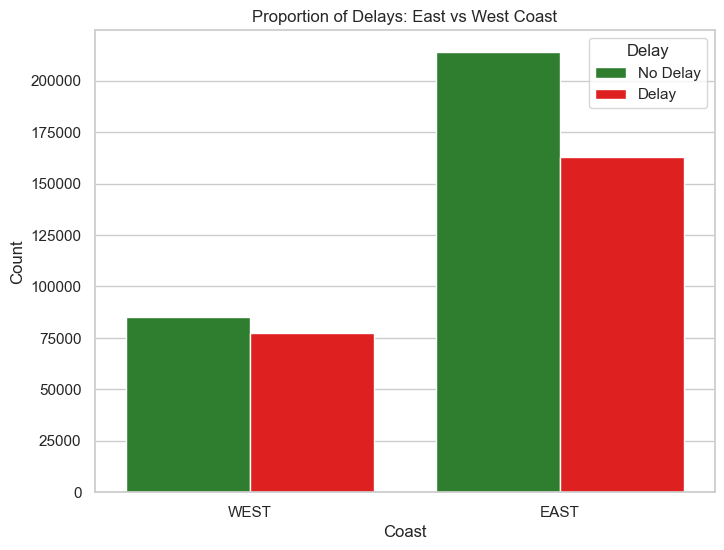

In [38]:
colors = ["#228B22", "#FF0000"]
plt.figure(figsize=(8, 6))
sns.countplot(x='FromCoast', hue='Delay', data=df, palette=colors)
plt.title('Proportion of Delays: East vs West Coast')
plt.xlabel('Coast')
plt.ylabel('Count')
plt.legend(title='Delay', labels=['No Delay', 'Delay'])
plt.show()

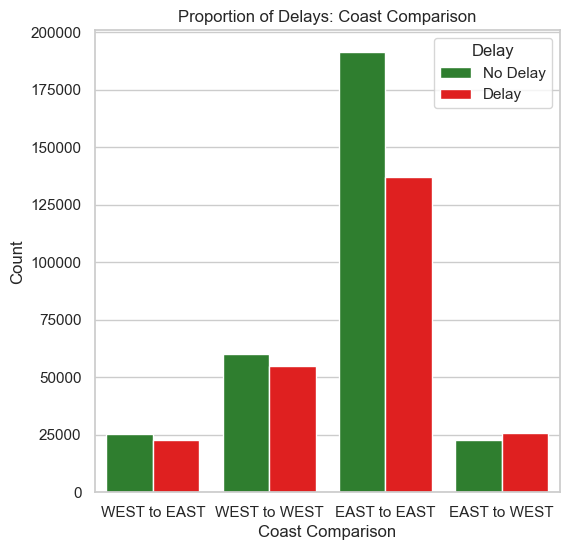

In [39]:
df['CoastComparison'] = df['FromCoast'] + ' to ' + df['ToCoast']

# grouped bar plot
plt.figure(figsize=(6, 6))
sns.countplot(x='CoastComparison', hue='Delay', data=df, palette=colors)
plt.title('Proportion of Delays: Coast Comparison')
plt.xlabel('Coast Comparison')
plt.ylabel('Count')
plt.legend(title='Delay', labels=['No Delay', 'Delay'])
plt.show()


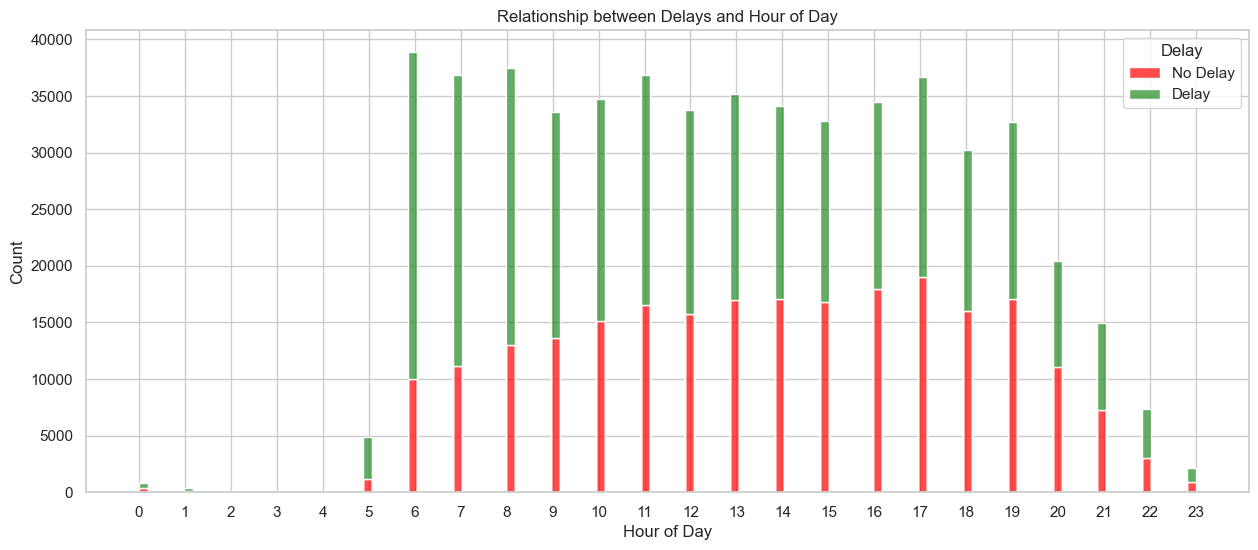

In [40]:
plt.figure(figsize=(15, 6))
sns.histplot(x='HourOfDay', hue='Delay', data=df, multiple='stack', palette=colors, element="step", alpha=0.7)

plt.title('Relationship between Delays and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.legend(title='Delay', labels=['No Delay', 'Delay'])

plt.xticks(range(24))
plt.show()


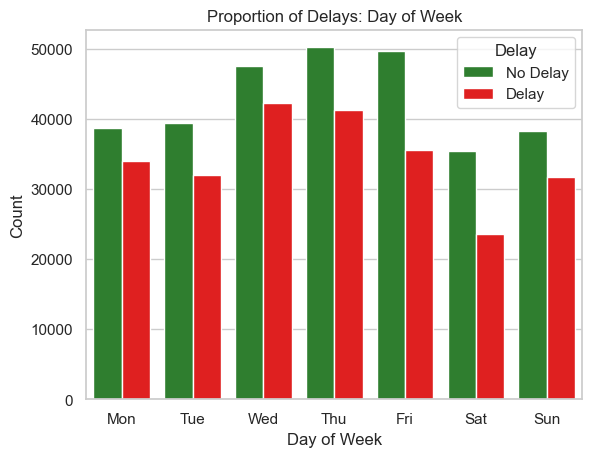

In [41]:
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# create the countplot
sns.countplot(data=df, x='DayOfWeek', hue='Delay', palette=colors)

plt.xticks(ticks=range(7), labels=day_names)
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.title('Proportion of Delays: Day of Week')
plt.legend(title='Delay', labels=['No Delay', 'Delay'])
plt.show()

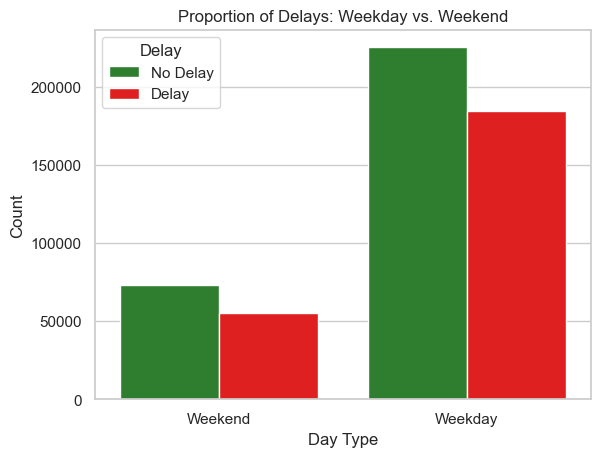

In [42]:
sns.countplot(data=df, x='DayType', hue='Delay', palette=colors)

plt.xticks(ticks=[0, 1], labels=['Weekend', 'Weekday'])
plt.xlabel('Day Type')
plt.ylabel('Count')
plt.title('Proportion of Delays: Weekday vs. Weekend')
plt.legend(title='Delay', labels=['No Delay', 'Delay'])
plt.show()


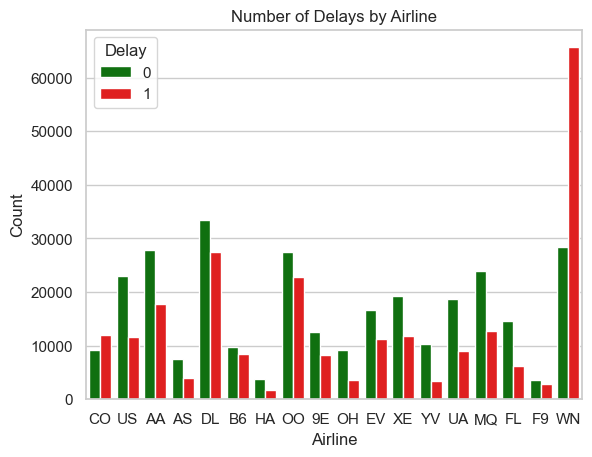

In [43]:
sns.set_palette(sns.color_palette(['green', 'red']))

sns.countplot(data=df, x='Airline', hue='Delay')

plt.title('Number of Delays by Airline')
plt.xlabel('Airline')
plt.ylabel('Count')

plt.show()


**Statistical Analysis:** Chi-square test and T-test

In [44]:
numerical_correlation = df[['Length', 'HourOfDay', 'Delay']].corr()

# create contingency tables for 'Airline', 'DayOfWeekName', and 'FlightType' against 'Delay'
def chi_square_test(data, column):
    contingency_table = pd.crosstab(data[column], data['Delay'])
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    return chi2, p

# chi-square test for 'Airline'
chi2_airline, p_airline = chi_square_test(df, 'Airline')

# for 'DayOfWeekName'
chi2_day, p_day = chi_square_test(df, 'DayOfWeekName')

# for 'FlightType'
chi2_type, p_type = chi_square_test(df, 'FlightType')

numerical_correlation, (chi2_airline, p_airline), (chi2_day, p_day), (chi2_type, p_type)

(             Length  HourOfDay     Delay
 Length     1.000000  -0.020668  0.040489
 HourOfDay -0.020668   1.000000  0.149448
 Delay      0.040489   0.149448  1.000000,
 (38193.57060142544, 0.0),
 (1178.1207446422304, 2.6007280556738458e-251),
 (1349.4505740952222, 9.34396137714549e-294))

In [45]:
# t-test beteen west coast and east coast delays
west_coast_delay = df[df['FromCoast'] == 'WEST']['Delay']
east_coast_delay = df[df['FromCoast'] == 'EAST']['Delay']

t_stat, p_value = ttest_ind(west_coast_delay, east_coast_delay, equal_var=False)

# print results
print("T-Statistic:", t_stat)
print("P-Value:", p_value)

# interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in delays between West Coast and East Coast flights.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in delays between West Coast and East Coast flights.")


T-Statistic: 29.551532636816972
P-Value: 1.1686403652806876e-191
Reject the null hypothesis: There is a significant difference in delays between West Coast and East Coast flights.


**Machine Learning:** Decision Tree and Logistic Regression on various features. Must also convert catagorial features into numerical inputs so they may be fed into the machine learning classifiers.

In [46]:
# define features and target variable
features = ['Airline', 'DayOfWeek', 'HourOfDay', 'FlightType', 'Length']
X = df[features]
y = df['Delay']

# applying one-hot encoding to categorical variables
categorical_features = ['Airline', 'DayOfWeek', 'FlightType']
one_hot_encoder = OneHotEncoder()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', one_hot_encoder, categorical_features)
    ],
    remainder='passthrough'
)

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# creating classifier pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# fit the data
dt_pipeline.fit(X_train, y_train)

# predictions
dt_predictions = dt_pipeline.predict(X_test)

# accuracy and classification report
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_classification_report = classification_report(y_test, dt_predictions)

print(f"Decision Tree Accuracy: {dt_accuracy:.4f}\n")
print("Classification Report:")
print(dt_classification_report)

Decision Tree Accuracy: 0.6171

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.72      0.67     89905
           1       0.58      0.49      0.53     71910

    accuracy                           0.62    161815
   macro avg       0.61      0.60      0.60    161815
weighted avg       0.61      0.62      0.61    161815



In [49]:
plt.figure(figsize=(10, 5))
plot_tree(dt_pipeline.named_steps['classifier'], filled=True, feature_names=preprocessor.get_feature_names_out(X_train.columns), max_depth=1)
plt.title("Decision Tree - Max Depth 1")
plt.show()

InvalidParameterError: The 'feature_names' parameter of plot_tree must be an instance of 'list' or None. Got array(['cat__Airline_9E', 'cat__Airline_AA', 'cat__Airline_AS',
       'cat__Airline_B6', 'cat__Airline_CO', 'cat__Airline_DL',
       'cat__Airline_EV', 'cat__Airline_F9', 'cat__Airline_FL',
       'cat__Airline_HA', 'cat__Airline_MQ', 'cat__Airline_OH',
       'cat__Airline_OO', 'cat__Airline_UA', 'cat__Airline_US',
       'cat__Airline_WN', 'cat__Airline_XE', 'cat__Airline_YV',
       'cat__DayOfWeek_1', 'cat__DayOfWeek_2', 'cat__DayOfWeek_3',
       'cat__DayOfWeek_4', 'cat__DayOfWeek_5', 'cat__DayOfWeek_6',
       'cat__DayOfWeek_7', 'cat__FlightType_Long-haul',
       'cat__FlightType_Medium-haul', 'cat__FlightType_Short-haul',
       'remainder__HourOfDay', 'remainder__Length'], dtype=object) instead.

<Figure size 1000x500 with 0 Axes>

In [ ]:
# logistic Regression
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(max_iter=1000, random_state=42))])

# training the Logistic Regression model
lr_pipeline.fit(X_train, y_train)

# predictions with Logistic Regression
lr_predictions = lr_pipeline.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_classification_report = classification_report(y_test, lr_predictions)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}\n")
print("Classification Report:")
print(lr_classification_report)



Logistic Regression Accuracy: 0.6340

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.78      0.70     89905
           1       0.62      0.45      0.52     71910

    accuracy                           0.63    161815
   macro avg       0.63      0.62      0.61    161815
weighted avg       0.63      0.63      0.62    161815



We will now plot a Receiver Operating Characteristic (ROC) curve which is a representation that illistrates the performance of our binary classification model. It plots the True Positive Rate (Sensitivity) against False Positive Rate. This is done at various threshold settings.

True Positive Rate = # True positives / (# True positives + # False Negatives)

True Positive Rate = # Delayed predicted as Delayed / (# Delayed predicted as Delayed + # Delayed predicted as not Delayed)

False Positive Rate = # False positives / (# False Positives + # True Negatives)

False Positive Rate = # Not delayed predicted as Delayed / (# Not delayed predicted as Delayed + # Not delayed predicted as delayed)

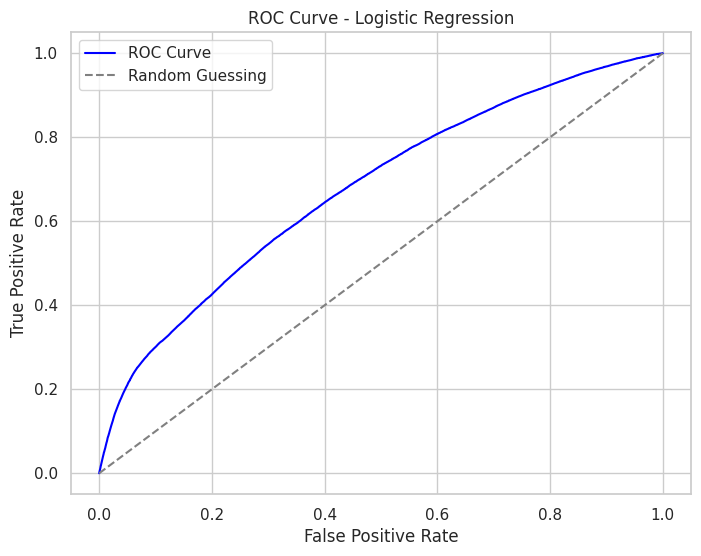

In [ ]:
# plot the ROC curve
lr_probabilities = lr_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, lr_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

In [ ]:
# parameter tuning

# decision Tree - max_depth tuning
dt_depths = [3, 5, 10, 15, 20]
dt_accuracy_scores = {}

for depth in dt_depths:
    dt_pipeline.set_params(classifier__max_depth=depth)
    dt_pipeline.fit(X_train, y_train)
    dt_pred = dt_pipeline.predict(X_test)
    dt_accuracy_scores[depth] = accuracy_score(y_test, dt_pred)

# logistic Regression - C (inverse of regularization strength) tuning
lr_C_values = [0.01, 0.1, 1, 10, 100]
lr_accuracy_scores = {}

for C in lr_C_values:
    lr_pipeline.set_params(classifier__C=C)
    lr_pipeline.fit(X_train, y_train)
    lr_pred = lr_pipeline.predict(X_test)
    lr_accuracy_scores[C] = accuracy_score(y_test, lr_pred)

# print out scores to be graphed
dt_accuracy_scores, lr_accuracy_scores

({3: 0.6335691993943701,
  5: 0.6382473812687328,
  10: 0.6443654790964991,
  15: 0.6437289497265396,
  20: 0.6361214967710039},
 {0.01: 0.6337916756790162,
  0.1: 0.6337916756790162,
  1: 0.6340265117572537,
  10: 0.6341624694867596,
  100: 0.6341562895899638})

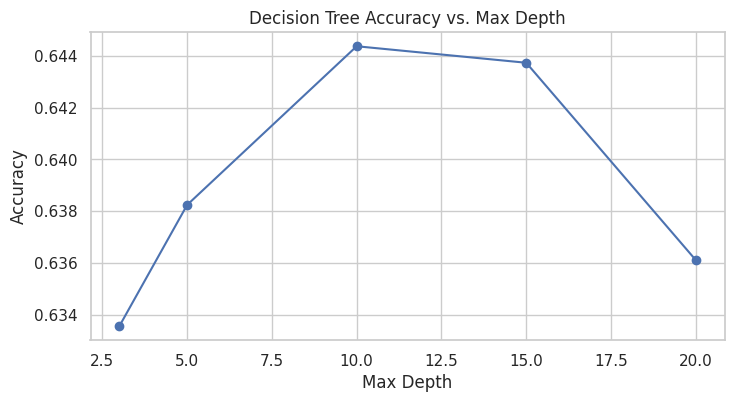

In [ ]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(dt_depths, list(dt_accuracy_scores.values()), marker='o', linestyle='-', color='b')
plt.title('Decision Tree Accuracy vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)

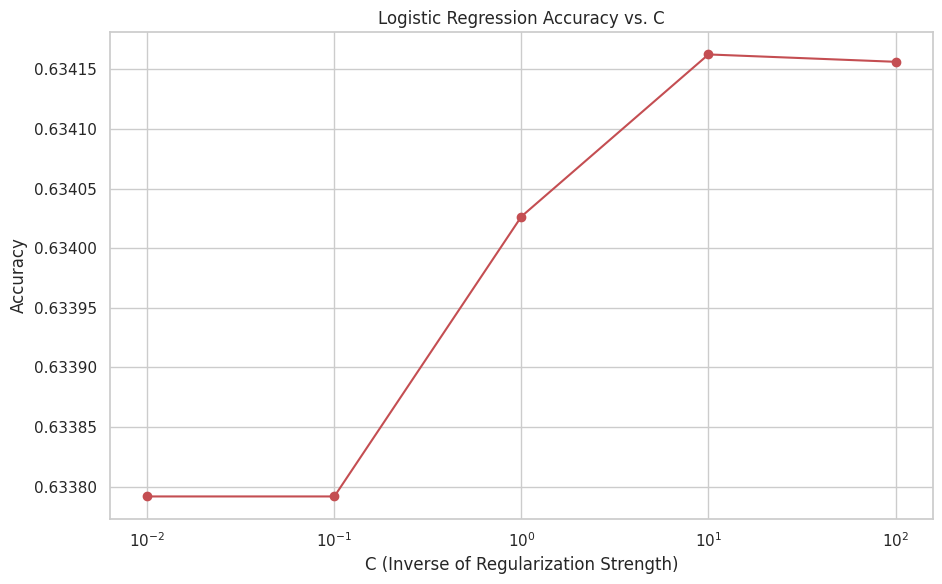

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 2)
plt.plot(lr_C_values, list(lr_accuracy_scores.values()), marker='o', linestyle='-', color='r')
plt.xscale('log')  # Set x-axis to a logarithmic scale
plt.xticks([.01, .1, 1, 10, 100])
plt.title('Logistic Regression Accuracy vs. C')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()
